# DeepFake Video Detection

# <a id='0'>Content</a>

- <a href='#1'>Introduction</a>  
- <a href='#2'>Preliminary data exploration</a>  
    * Load the packages  
    * Load the data  
    * Check files type  
- <a href='#3'>Meta data exploration</a>  
     * Missing data   
     * Unique values  
     * Most frequent originals  
- <a href='#4'>Video data exploration</a>  
     * Missing video (or meta) data  
     * Few fake videos  
     * Few real videos  
     * Videos with same original  
     * Test video files  
     * Play video files
- <a href='#5'>Face detection</a>  
- <a href='#6'>Resources</a> 
- <a href='#7'>References</a>     


# Introduction

**DeepFake**, derived from "Deep Learning" and "Fake," refers to the technology of taking one person's likeness from an image or video  
and replacing it with another's using Deep Artificial Neural Networks. Major companies invest heavily in combating DeepFakes to counter  
this threat. DeepFake is rapidly invading the film industry and threatens to compromise news agencies. Large digital companies, including  
content providers and social platforms, are at the forefront of fighting DeepFakes. GANs (Generative Adversarial Networks) that generate  
DeepFakes are improving daily. 

In the **Data Exploration** section, we perform a partial Exploratory Data Analysis (EDA) on the training and testing data. After checking  
the file types, we focus first on the **metadata** files, exploring them in detail after importing them into dataframes. We then explore  
video files by examining a sample of fake videos followed by real videos. Additionally, we analyze a few videos with the same origin, visualizing  
one frame from both real and fake videos and playing a few videos. 

Next, we perform face (and other objects from the persons in the videos) extraction using OpenCV Haar Cascade resources to identify frontal faces,  
eyes, smiles, and profile faces from still images in the videos.

**Important Note**: The data analyzed here is just a small sample. The competition specifies that the training data is provided in archived chunks.  
Models should be trained offline using the archived data provided by Kaggle. Models should then be loaded (max 1GB memory) into a Kernel for  
inference, and predictions should be prepared as an output file from the Kernel.  

In the **Resources** section, There is a short list of various resources for GAN and DeepFake, including blog  
posts, Kaggle Kernels, and GitHub repositories.

# <a id='2'>Preliminary data exploration</a>

### Datasets:
There are 4 groups of datasets associated with this competition.

1. **Training Set: This dataset containing labels for the target.**  
2. **Public Validation Set:** We trained our data using a small set of 400 videos/ids contained within this Public Validation Set.  
This is available on the Kaggle Data page as test_videos.zip  
3. **Public Test Set:**   
Our code is running this on Public Test Set. When the re-run is complete, the score will be displayed.  
4. **Private Test Set:**
This dataset is privately held outside of Kaggle’s platform, and is used to compute the private leaderboard. It contains videos  
with a similar format/nature as the Training & Public Validation/Test Sets, but are real, organic videos with and without deepfakes.  

### Workflow:
add more about the workflow

### **Evaluation**
$LogLoss = -\frac{1}{n} \sum_{1=1}^{n} \left[ y_{i} \log \left( \hat{y}_{i} \right) + \left(1 - y_{i}\right) \log \left(1 - \hat{y}_{i} \right) \right] \ $

where

* $n$ is the number of videos being predicted
* $\hat{y}_{i}$ is the predicted probability of the video being FAKE
* $y_{i}$ is 1 if the video is FAKE, 0 if REAL
* $\log( )$ is the natural (base e) logarithm = $\ln(  )$

A smaller log loss is better. The use of the logarithm provides extreme punishments for being both confident and wrong.  
In the worst possible case, a prediction that something is true when it is actually false will add infinite to your error score.  
In order to prevent this, predictions are bounded away from the extremes by a small value.

## Load packages

In [69]:
import numpy as np
import pandas as pd 
import os
import sys
import matplotlib 
import seaborn as sns 
import matplotlib.pyplot as plt 
from typing import Optional
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook 
import cv2 as cv 
import platform
import subprocess
import pyopencl as cl 
import tensorflow as tf
import getpass
import json
from rocm.configure import * 
from utils.video_dataset import *

from IPython.display import HTML
from base64 import b64encode

In [3]:
print("TensorFlow version:", tf.__version__)
print(sys.version)
print(f'Kernel mode driver status: {subprocess.run("dkms status", shell=True, capture_output=True, text=True).stdout}' )

TensorFlow version: 2.10.1
3.9.19 | packaged by conda-forge | (main, Mar 20 2024, 12:38:46) [MSC v.1929 64 bit (AMD64)]
Kernel mode driver status: 


### Constants

In [4]:
# DATASET
DATA_CONFIG = './configs/data_path.json'

with open(DATA_CONFIG, 'r') as f:
    data = json.load(f)

DATA_FOLDER = data['data path'][getpass.getuser()][0]
COMPRESSED_DATA_FOLDER = data['data path'][getpass.getuser()][1]
BATCH_SIZE = data['batch size']
DATA_DIRECTORIES = os.listdir(DATA_FOLDER)


DATA_SAMPLE_FOLDER = '../input/deepfake-detection'
TRAIN_SAMPLE_FOLDER = 'train_sample_videos'
TEST_FOLDER = 'test_videos'

# LIBS
FACE_DETECTION_FOLDER = '../input/haar-cascades-for-face-detection'

### Utility Functions

In [68]:
# UTILITY FUNCTIONS

# Function to display video
def play_video(video_file, subset=TRAIN_SAMPLE_FOLDER):
    '''
    Display video
    param: video_file - the name of the video file to display
    param: subset - the folder where the video file is located (can be TRAIN_SAMPLE_FOLDER or TEST_Folder)
    '''
    video_url = open(os.path.join(DATA_SAMPLE_FOLDER, subset,video_file),'rb').read()
    data_url = f"data:video/mp4;base64,{b64encode(video_url).decode()}"
    return HTML(f"""<video width=500 controls><source src="{data_url}" type="video/mp4"></video>""")

# Function to display image from a video
def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    ax.imshow(frame)
# Function to get the OpenCL platform information
def get_platform_info():
    platforms = cl.get_platforms()
    for platform in platforms:
        devices = platform.get_devices()
        print(f"Platform Name: {platform.get_info(cl.platform_info.NAME)}")
        print(f"Platform Vendor: {platform.get_info(cl.platform_info.VENDOR)}")
        print(f"Platform Version: {platform.get_info(cl.platform_info.VERSION)}")
        print(f"Platform Profile: {platform.get_info(cl.platform_info.PROFILE)}")
        for device in devices:
            print(f"Device: {device.name}")

    amd_platform = next(
        (platform for platform in platforms if 'AMD' in platform.name), None
    )

# Function to check unique values in a dataset
def unique_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    uniques = []
    for col in data.columns:
        unique = data[col].nunique()
        uniques.append(unique)
    tt['Uniques'] = uniques
    return(np.transpose(tt))

# Function to check missing data in a dataset
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

# Function to check the most frequent values in a dataset
def most_frequent_values(data):
    total = data.count()
    tt = pd.DataFrame(total)
    tt.columns = ['Total']
    items = []
    vals = []
    for col in data.columns:
        itm = data[col].value_counts().index[0]
        val = data[col].value_counts().values[0]
        items.append(itm)
        vals.append(val)
    tt['Most frequent item'] = items
    tt['Frequency'] = vals
    tt['Percent from total'] = np.round(vals / total * 100, 3)
    return(np.transpose(tt))

# Function to plot the count of classes in a dataset
def plot_count(feature, title, df, size=1):
    '''
    Plot count of classes / feature
    param: feature - the feature to analyze
    param: title - title to add to the graph
    param: df - dataframe from which we plot feature's classes distribution 
    param: size - default 1.
    '''
    f, ax = plt.subplots(1,1, figsize=(4*size,4))
    total = float(len(df))
    g = sns.countplot(x=feature, data=df, order=df[feature].value_counts().index[:20], palette='Set3', hue=feature, legend=False)
    g.set_title(f"Histogram of {title}")
    if(size > 2):
        plt.xticks(rotation=90, size=8)
    for p in ax.patches:
        height = p.get_height()
        ax.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(100*height/total),
                ha="center")
    plt.show()

# Function read video metadata from json files
def read_meta_from_json(data_directories, data_folder, compressed_data_folder):
    
    meta_df = pd.DataFrame()

    for index, part_folder in enumerate(data_directories):
        part_path = os.path.join(data_folder, part_folder)
        json_file = next(file for file in os.listdir(part_path) if file.endswith('json'))
        json_file_path = os.path.join(part_path, json_file)
        
        part_df = pd.read_json(json_file_path).T
        part_df['part'] = index
        part_df['path'] = part_path
        part_df['path-compressed'] =  os.path.join(compressed_data_folder, os.path.basename(part_path))
        part_df['filename'] = part_df.index
        
        meta_df = pd.concat([meta_df, part_df])

    # Display 5 random rows from meta_df
    display(meta_df.sample(n=5))
    return meta_df

# Function to display image from a video
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list[:6]):
        video_path = os.path.join(DATA_SAMPLE_FOLDER, video_folder,video_file)
        capture_image = cv.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')
        
# Function from moviepy.editor import AudioFileClip
def LoadVideo(filepath, down_fps, scale_fact, isGray):
    video = []
    
    # Open the video file
    cap = cv.VideoCapture(filepath)
    
    # Get video properties
    fps = cap.get(cv.CAP_PROP_FPS)  # Frames per second
    fcnt = int(cap.get(cv.CAP_PROP_FRAME_COUNT))  # Total number of frames
    fps_factor = round(fps / down_fps)  # Factor to downsample frames
    
    # Loop through each frame
    for ii_f in range(fcnt):
        if cap.isOpened() == False:
            break
        
        # Read the next frame
        ret, frame = cap.read()
        
        if (ii_f % fps_factor) != 0:  # Downsample frames
            continue
        
        # Check if frame is read correctly
        if not ret:
            break
        
        # Get frame dimensions and rotate if necessary
        height, width, channels = frame.shape
        if height > width:
            frame = cv.rotate(frame, cv.ROTATE_90_CLOCKWISE)
            height, width, channels = frame.shape
        
        # Calculate downscaled dimensions
        down_width = round(width * scale_fact)
        down_height = round(height * scale_fact)
        down_points = (down_width, down_height)
        
        # Resize and convert frame to grayscale if specified
        if isGray:
            frame_sample = cv.resize(cv.cvtColor(frame, cv.COLOR_BGR2GRAY), down_points, interpolation=cv.INTER_LINEAR)
        else:
            frame_sample = cv.resize(cv.cvtColor(frame, cv.COLOR_BGR2RGB), down_points, interpolation=cv.INTER_LINEAR)
        
        # Append resized frame to video list
        video.append(frame_sample)

    # Release the video capture object and close all windows
    cap.release()
    cv.destroyAllWindows()
    
    # Convert video list to numpy array and then to torch tensor
    video = np.array(video)
    video = torch.tensor(video)
    
    return video

### Add configurations for AMD GPU - Ubuntu only
1. ADD rocm binary paths to the PATH environment variable.
2. ADD open CL to LD_LIBRARY_PATH
3. ADD user to "render" and "video" groups
4. INSTALL clinfo
5. INSTALL ocl-icd
6. USE rocm-smi to check GPU's performance

In [6]:
if platform.system() == 'Linux' and 'Ubuntu' in platform.version():
    add_rocm_to_path()
    add_ld_library_path()
    check_user_in_groups()
    install_clinfo()
    install_ocl_icd()
    rocm_smi()
    clinfo()
    rocminfo()

### Find physical devices (CPU and GPU)

check that the cpu and gpu are recognized by tensorflow

In [7]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Num CPUs Available: ", len(tf.config.list_physical_devices('CPU')))

Num GPUs Available:  1
Num CPUs Available:  1


### Limit GPU resource to enable resources for casual work

TensorFlow allocates all of the GPU’s memory by default, leaving nothing for the desktop environment and any  
other apps to use. In order to solve this issue, we save some resources aside for casual workload and maintenance resources.

In [8]:
if gpus := tf.config.experimental.list_physical_devices('GPU'):
  try:
    get_platform_info()
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
  except RuntimeError as e:
    print(e)


Platform Name: AMD Accelerated Parallel Processing
Platform Vendor: Advanced Micro Devices, Inc.
Platform Version: OpenCL 2.1 AMD-APP (3592.0)
Platform Profile: FULL_PROFILE
Device: gfx1100


## Load data

In [9]:
print(f"Train samples: {len(os.listdir(os.path.join(DATA_SAMPLE_FOLDER, TRAIN_SAMPLE_FOLDER)))}")
print(f"Test samples: {len(os.listdir(os.path.join(DATA_SAMPLE_FOLDER, TEST_FOLDER)))}")

Train samples: 401
Test samples: 400


We also added a face detection resource.

In [10]:
print(f"Face detection resources: {os.listdir(FACE_DETECTION_FOLDER)}")

Face detection resources: ['haarcascade_eye.xml', 'haarcascade_eye_tree_eyeglasses.xml', 'haarcascade_frontalface_alt.xml', 'haarcascade_frontalface_alt2.xml', 'haarcascade_frontalface_alt_tree.xml', 'haarcascade_frontalface_default.xml', 'haarcascade_fullbody.xml', 'haarcascade_profileface.xml', 'haarcascade_smile.xml', 'haarcascade_upperbody.xml']


## Check files type

Here we check the train data files extensions. Most of the files looks to have `mp4` extension, let's check if there is other extension as well.

In [11]:
train_list = list(os.listdir(os.path.join(DATA_SAMPLE_FOLDER, TRAIN_SAMPLE_FOLDER)))
ext_dict = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")  

Extensions: ['mp4', 'json']


Let's count how many files with each extensions there are.

---

In [12]:
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in train_list if  file.endswith(file_ext)])}")

Files with extension `mp4`: 400
Files with extension `json`: 1


Let's repeat the same process for test videos folder.

In [13]:
test_list = list(os.listdir(os.path.join(DATA_SAMPLE_FOLDER, TEST_FOLDER)))
ext_dict = []
for file in test_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict):
        ext_dict.append(file_ext)
print(f"Extensions: {ext_dict}")
for file_ext in ext_dict:
    print(f"Files with extension `{file_ext}`: {len([file for file in train_list if  file.endswith(file_ext)])}")

Extensions: ['mp4']
Files with extension `mp4`: 400


Let's check the `json` file first.

In [14]:
json_file = [file for file in train_list if  file.endswith('json')][0]
print(f"JSON file: {json_file}")

JSON file: metadata.json


Apparently here is a metadata file. Let's explore this JSON file.

In [15]:
def get_meta_from_json(path):
    df = pd.read_json(os.path.join(DATA_FOLDER, path, json_file))
    df = df.T
    return df

meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)
meta_train_df.head()

,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


# <a id="3">Meta data exploration</a>

Let's explore now the meta data in train sample. 

## Missing data

We start by checking for any missing values. 

In [16]:
missing_data(meta_train_df)

,label,split,original
Total,0,0,77
Percent,0.0,0.0,19.25
Types,object,object,object


There are missing data 19.25% of the samples (or 77). We suspect that actually the real data has missing original (if we generalize from the data we glimpsed). Let's check this hypothesis.

In [17]:
missing_data(meta_train_df.loc[meta_train_df.label=='REAL'])

,label,split,original
Total,0,0,77
Percent,0.0,0.0,100.0
Types,object,object,object


Indeed, all missing `original` data are the one associated with `REAL` label.  

## Unique values;

Let's check into more details the unique values.

In [18]:
unique_values(meta_train_df)

,label,split,original
Total,400,400,323
Uniques,2,1,209


* We observe that `original` label has the same pattern for uniques values. We know that we have 77 missing data (that's why total is only 323) and we observe that we do have 209 unique examples.  

## Most frequent originals

Let's look now to the most frequent originals uniques in train sample data.  

In [19]:
most_frequent_values(meta_train_df)

,label,split,original
Total,400,400,323
Most frequent item,FAKE,train,atvmxvwyns.mp4
Frequency,323,400,6
Percent from total,80.75,100.0,1.858


We see that most frequent **label** is `FAKE` (80.75%), `meawmsgiti.mp4` is the most frequent **original** (6 samples).

Let's do now some data distribution visualizations.

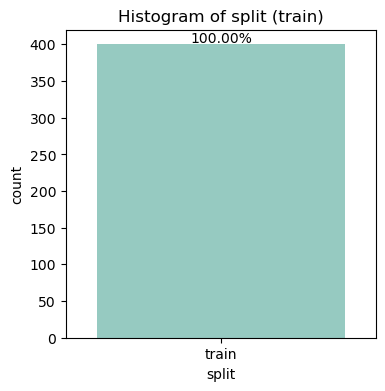

In [20]:
plot_count('split', 'split (train)', meta_train_df)

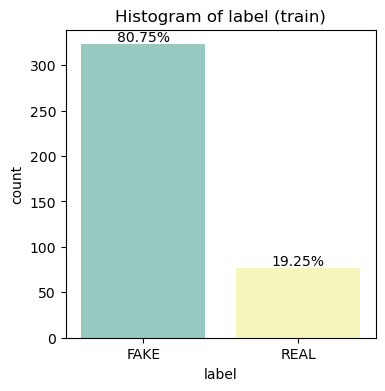

In [21]:
plot_count('label', 'label (train)', meta_train_df)

As we can see, the `REAL` are only 19.25% in train sample videos, with the `FAKE`s acounting for 80.75% of the samples. 


# <a id="4">Video data exploration</a>


In the following we will explore some of the video data. 


## Missing video (or meta) data

We check first if the list of files in the meta info and the list from the folder are the same.

In [22]:
meta = np.array(list(meta_train_df.index))
storage = np.array([file for file in train_list if  file.endswith('mp4')])
print(f"Metadata: {meta.shape[0]}, Folder: {storage.shape[0]}")
print(f"Files in metadata and not in folder: {np.setdiff1d(meta,storage,assume_unique=False).shape[0]}")
print(f"Files in folder and not in metadata: {np.setdiff1d(storage,meta,assume_unique=False).shape[0]}")

Metadata: 400, Folder: 400
Files in metadata and not in folder: 0
Files in folder and not in metadata: 0


Let's visualize now the data.  

We select first a list of fake videos.

## Few fake videos

In [23]:
fake_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='FAKE'].sample(3).index)
fake_train_sample_video

['avgiuextiz.mp4', 'esxrvsgpvb.mp4', 'cdphtzqrvp.mp4']

From [4] ([Basic EDA Face Detection, split video, ROI](https://www.kaggle.com/marcovasquez/basic-eda-face-detection-split-video-roi)) we modified a function for displaying a selected image from a video.

In [24]:
# for video_file in fake_train_sample_video:
#     display_image_from_video(os.path.join(DATA_SAMPLE_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

Let's try now the same for few of the images that are real.  


## Few real videos

In [25]:
real_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='REAL'].sample(3).index)
real_train_sample_video

['clrycekyst.mp4', 'beboztfcme.mp4', 'bddjdhzfze.mp4']

In [26]:
# for video_file in real_train_sample_video:
#     display_image_from_video(os.path.join(DATA_SAMPLE_FOLDER, TRAIN_SAMPLE_FOLDER, video_file))

## Videos with same original

Let's look now to set of samples with the same original.

In [27]:
# meta_train_df['original'].value_counts()[:5]

We pick one of the originals with largest number of samples.   

We also modify our visualization function to work with multiple images.

In [28]:
# same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='meawmsgiti.mp4'].index)
# display_image_from_video_list(same_original_fake_train_sample_video)

Let's look now to a different selection of videos with the same original. 

In [29]:
# same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='atvmxvwyns.mp4'].index)
# display_image_from_video_list(same_original_fake_train_sample_video)

In [30]:
# same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='qeumxirsme.mp4'].index)
# display_image_from_video_list(same_original_fake_train_sample_video)

In [31]:
 # same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='kgbkktcjxf.mp4'].index)
 # display_image_from_video_list(same_original_fake_train_sample_video)

## Test video files

Let's also look to few of the test data files.

In [32]:
test_videos = pd.DataFrame(list(os.listdir(os.path.join(DATA_SAMPLE_FOLDER, TEST_FOLDER))), columns=['video'])

In [33]:
# test_videos.head()

Let's visualize now one of the videos.

In [34]:
# display_image_from_video(os.path.join(DATA_SAMPLE_FOLDER, TEST_FOLDER, test_videos.iloc[0].video))

Let's look to some more videos from test set.

In [35]:
# display_image_from_video_list(test_videos.sample(6).video, TEST_FOLDER)

# <a id='5'>Face detection</a>  

From [5] ([Face Detection using OpenCV](https://www.kaggle.com/serkanpeldek/face-detection-with-opencv)) by [@serkanpeldek](https://www.kaggle.com/serkanpeldek) we got and slightly modified the functions to extract face, profile face, eyes and smile.  

The class ObjectDetector initialize the cascade classifier (using the imported resource). The function **detect** uses a method of the CascadeClassifier to detect objects into images - in this case the face, eye, smile or profile face.

In [36]:
class ObjectDetector():
    '''
    Class for Object Detection
    '''
    
    def __init__(self,object_cascade_path):
        '''
        param: object_cascade_path - path for the *.xml defining the parameters for {face, eye, smile, profile}
        detection algorithm
        source of the haarcascade resource is: https://github.com/opencv/opencv/tree/master/data/haarcascades
        '''

        self.objectCascade=cv.CascadeClassifier(object_cascade_path)


    def detect(self, image, 
               scale_factor=1.3,
               min_neighbors=5,
               min_size=(20,20)):
        '''
        Function return rectangle coordinates of object for given image
        param: image - image to process
        param: scale_factor - scale factor used for object detection
        param: min_neighbors - minimum number of parameters considered during object detection
        param: min_size - minimum size of bounding box for object detected
        '''
        return self.objectCascade.detectMultiScale(
            image,
            scaleFactor=scale_factor,
            minNeighbors=min_neighbors,
            minSize=min_size,
        )

We load the resources for frontal face, eye, smile and profile face detection.  

Then we initialize the `ObjectDetector` objects defined above with the respective resources, to use CascadeClassifier for each specific task.

In [37]:
# Frontal face, profile, eye and smile  haar cascade loaded

frontal_path = f"{FACE_DETECTION_FOLDER}/haarcascade_frontalface_default.xml"
eye_path = f"{FACE_DETECTION_FOLDER}/haarcascade_eye.xml"
profile_path = f"{FACE_DETECTION_FOLDER}/haarcascade_profileface.xml"
smile_path = f"{FACE_DETECTION_FOLDER}/haarcascade_smile.xml"
paths_list = [frontal_path, eye_path, profile_path, smile_path]

#Detector object created
front_d, eye_d, prof_d, smile_d = [ObjectDetector(path) for path in paths_list]


We also define a function for detection and display of all these specific objects.  

The function call the **detect** method of the **ObjectDetector** object. For each object we are using a different shape and color, as following:
* Frontal face: green rectangle;  
* Eye: red circle;  
* Smile: red rectangle;  
* Profile face: blue rectangle.  

Note: due to a huge amount of false positive, we deactivate for now the smile detector.

In [38]:
def detect_objects(image, scale_factor, min_neighbors, min_size):
    '''
    Objects detection function
    Identify frontal face, eyes, smile and profile face and display the detected objects over the image
    param: image - the image extracted from the video
    param: scale_factor - scale factor parameter for `detect` function of ObjectDetector object
    param: min_neighbors - min neighbors parameter for `detect` function of ObjectDetector object
    param: min_size - minimum size parameter for f`detect` function of ObjectDetector object
    '''
    
    image_gray=cv.cvtColor(image, cv.COLOR_BGR2GRAY)


    eyes=eye_d.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=(int(min_size[0]/2), int(min_size[1]/2)))

    for x, y, w, h in eyes:
        #detected eyes shown in color image
        cv.circle(image,(int(x+w/2),int(y+h/2)),(int((w + h)/4)),(0, 0,255),3)
 
    # deactivated due to many false positive
    #smiles=smile_d.detect(image_gray,
    #               scale_factor=scale_factor,
    #               min_neighbors=min_neighbors,
    #               min_size=(int(min_size[0]/2), int(min_size[1]/2)))

    #for x, y, w, h in smiles:
    #    #detected smiles shown in color image
    #    cv.rectangle(image,(x,y),(x+w, y+h),(0, 0,255),3)


    profiles=prof_d.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=min_size)

    for x, y, w, h in profiles:
        #detected profiles shown in color image
        cv.rectangle(image,(x,y),(x+w, y+h),(255, 0,0),3)

    faces=front_d.detect(image_gray,
                   scale_factor=scale_factor,
                   min_neighbors=min_neighbors,
                   min_size=min_size)

    for x, y, w, h in faces:
        #detected faces shown in color image
        cv.rectangle(image,(x,y),(x+w, y+h),(0, 255,0),3)

    # image
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    ax.imshow(image)

The following function extracts an image from a video and then call the function that extracts the face rectangle from the image and display the rectangle above the image.

In [39]:
def extract_image_objects(video_file, video_set_folder=TRAIN_SAMPLE_FOLDER):
    '''
    Extract one image from the video and then perform face/eyes/smile/profile detection on the image
    param: video_file - the video from which to extract the image from which we extract the face
    '''
    video_path = os.path.join(DATA_FOLDER, video_set_folder,video_file)
    capture_image = cv.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    #frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    detect_objects(image=frame, scale_factor=1.3, min_neighbors=5, min_size=(50, 50))

We apply the function for face detection for a selection of images from train sample videos.

In [40]:
# same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='kgbkktcjxf.mp4'].index)
# for video_file in same_original_fake_train_sample_video[1:4]:
#     print(video_file)
#     extract_image_objects(video_file)

In [41]:
# train_subsample_video = list(meta_train_df.sample(3).index)
# for video_file in train_subsample_video:
#     print(video_file)
#     extract_image_objects(video_file)

Let's look to a small collection of samples from test videos.

In [42]:
# subsample_test_videos = list(test_videos.sample(3).video)
# for video_file in subsample_test_videos:
#     print(video_file)
#     extract_image_objects(video_file, TEST_FOLDER)

We can observe that in some cases, when the subject is not looking frontally or when the luminosity is low, the algorithm for face detection is not detecting the face or eyes correctly. Due to a large amount of false positive, we deactivated for now the smile detector.

## Play video files  

From [Play video and processing](https://www.kaggle.com/hamditarek/play-video-and-processing) Kernel by [@hamditarek](https://www.kaggle.com/hamditarek) we learned how to play video files in a Kaggle Kernel.  
Let's look to few fake videos.

In [43]:
fake_videos = list(meta_train_df.loc[meta_train_df.label=='FAKE'].index)

In [44]:
# play_video(fake_videos[0])

In [45]:
# play_video(fake_videos[1])

In [46]:
# play_video(fake_videos[2])

In [47]:
# play_video(fake_videos[3])

In [48]:
# play_video(fake_videos[4])

In [49]:
# play_video(fake_videos[5])

In [50]:
# play_video(fake_videos[10])

In [51]:
# play_video(fake_videos[12])

In [52]:
# play_video(fake_videos[15])

In [53]:
# play_video(fake_videos[18])

From visual inspection of these fakes videos, in some cases is very easy to spot the anomalies created when engineering the deep fake, in some cases is more difficult.

In [54]:
with open(DATA_CONFIG, 'r') as f:
    data = json.load(f)

DATA_FOLDER = data['data path'][getpass.getuser()][0]
COMPRESSED_DATA_FOLDER = data['data path'][getpass.getuser()][1]
BATCH_SIZE = data['batch size']
DATA_DIRECTORIES = os.listdir(DATA_FOLDER)

### Read meta data into Pandas' DataFrame

In [55]:
meta_df = read_meta_from_json(DATA_DIRECTORIES, DATA_FOLDER, COMPRESSED_DATA_FOLDER)

,label,split,original,part,path,path-compressed,filename
qdjfbfqwau.mp4,FAKE,train,lkjgzcuaoi.mp4,4,F:\dfdc\dfdc_train_part_12,F:\dfdc-comp\dfdc_train_part_12,qdjfbfqwau.mp4
shenidieml.mp4,FAKE,train,abzkauwmbl.mp4,38,F:\dfdc\dfdc_train_part_43,F:\dfdc-comp\dfdc_train_part_43,shenidieml.mp4
pruskulhhm.mp4,FAKE,train,osyfcyjccv.mp4,39,F:\dfdc\dfdc_train_part_44,F:\dfdc-comp\dfdc_train_part_44,pruskulhhm.mp4
mkejzspdrg.mp4,FAKE,train,fpodzuuebt.mp4,27,F:\dfdc\dfdc_train_part_33,F:\dfdc-comp\dfdc_train_part_33,mkejzspdrg.mp4
ehrsmbkjtb.mp4,FAKE,train,bmrwcqrpyp.mp4,8,F:\dfdc\dfdc_train_part_16,F:\dfdc-comp\dfdc_train_part_16,ehrsmbkjtb.mp4


### Total number of videos in the dataset

In [56]:
print(f"Data samples: {len(meta_df)}")

Data samples: 119154


### Full data set exploration

1. Histogram

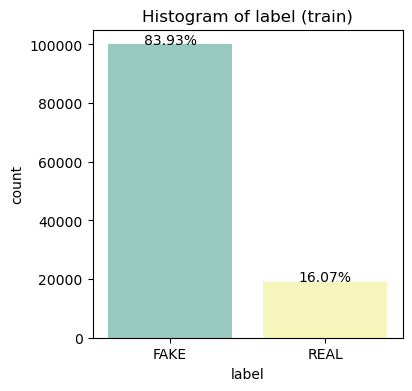

In [57]:
plot_count('label', 'label (train)', meta_df)

### Use DataLoader to load the videos 

1. **shuffle:** ON
2. **batch size:** 3
3. **source:** DATA_FOLDER
4. **compressed data:** COMPRESSED_DATA_FOLDER

In [58]:
loader = DataLoader(VideoDataset(DATA_FOLDER, 'train'), batch_size=3, shuffle=True)

In [59]:
# data, label = next(iter(loader))
# fig = plt.figure(figsize=(12, 12))

# for i in range(BATCH_SIZE):
#   video = data[i]
#   fig.add_subplot(BATCH_SIZE, 3, BATCH_SIZE*i + 1)
#   plt.imshow(video[0])
#   fig.add_subplot(BATCH_SIZE, 3, BATCH_SIZE*i + 2)
#   plt.imshow(video[100])
#   fig.add_subplot(BATCH_SIZE, 3, BATCH_SIZE*i + 3)
#   plt.imshow(video[-1])

# print(label)


In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import glob

class TensorDataset(Dataset):
    def __init__(self, tensor_files):
        self.tensor_files = tensor_files

    def __len__(self):
        return len(self.tensor_files)

    def __getitem__(self, idx):
        tensor_data = torch.load(self.tensor_files[idx])
        inputs = tensor_data['inputs']  # Assuming the file contains a dictionary with 'inputs'
        labels = tensor_data['labels']  # Assuming the file contains a dictionary with 'labels'
        return inputs, labels

# List all tensor files in a directory
tensor_files = glob.glob('path_to_tensor_files/*.pt')

# Create the dataset
dataset = TensorDataset(tensor_files)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=2)

In [67]:
import torch
from efficientnet_pytorch_3d import EfficientNet3D
from torchsummary import summary

# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the appropriate device
model = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1).to(device)

# Print model summary with the input size
summary(model, input_size=(1, 200, 200, 200), device=str(device))

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Training loop
model.train()
for epoch in range(2):
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 10 == 9:    # Print every 10 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1     [-1, 1, 201, 201, 201]               0
Conv3dStaticSamePadding-2    [-1, 32, 100, 100, 100]             864
       BatchNorm3d-3    [-1, 32, 100, 100, 100]              64
MemoryEfficientSwish-4    [-1, 32, 100, 100, 100]               0
         ZeroPad2d-5    [-1, 32, 101, 101, 101]               0
Conv3dStaticSamePadding-6       [-1, 32, 50, 50, 50]             864
       BatchNorm3d-7       [-1, 32, 50, 50, 50]              64
MemoryEfficientSwish-8       [-1, 32, 50, 50, 50]               0
          Identity-9          [-1, 32, 1, 1, 1]               0
Conv3dStaticSamePadding-10           [-1, 8, 1, 1, 1]             264
MemoryEfficientSwish-11           [-1, 8, 1, 1, 1]               0
         Identity-12           [-1, 8, 1, 1, 1]               0
Conv3dStaticSamePadding-13          [-1, 32, 1, 1, 1]             288
         I

In [62]:
# Import necessary libraries and set environment variables
# os.environ["MKL_NUM_THREADS"] = "1"
# os.environ["NUMEXPR_NUM_THREADS"] = "1"
# os.environ["OMP_NUM_THREADS"] = "1"

# from albumentations import Compose, RandomBrightnessContrast, HorizontalFlip, FancyPCA, HueSaturationValue, OneOf, ToGray, ShiftScaleRotate, ImageCompression, PadIfNeeded, GaussNoise, GaussianBlur
# from utils.augmentation import IsotropicResize
# from collections import defaultdict
# from sklearn.metrics import log_loss
# from torch import topk
# import argparse
# import cv2
# from training import losses
# from training.losses import WeightedLosses
# from training.tools.config import load_config

# from utils import classifiers
# from tensorboardX import SummaryWriter
# from training.datasets.classifier_dataset import DeepFakeClassifierDataset
# # from training.tools.utils import create_optimizer, AverageMeter
# # from training.pipelines.train_classifier import train_epoch
# # from apex import amp
# # from apex.parallel import DistributedDataParallel, convert_syncbn_model
# import torch
# from torch.backends import cudnn
# from torch.nn import DataParallel
# from torch.utils.data import DataLoader
# from tqdm import tqdm
# import torch.distributed as dist

# torch.backends.cudnn.benchmark = True
# cv2.ocl.setUseOpenCL(False)
# cv2.setNumThreads(0)


In [ ]:
# # Train classifier functions

# # Create training data transformations
# def create_train_transforms(size=300):
#     return Compose([
#         ImageCompression(quality_lower=60, quality_upper=100, p=0.5),
#         GaussNoise(p=0.1),
#         GaussianBlur(blur_limit=3, p=0.05),
#         HorizontalFlip(),
#         OneOf([
#             IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
#             IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_LINEAR),
#             IsotropicResize(max_side=size, interpolation_down=cv2.INTER_LINEAR, interpolation_up=cv2.INTER_LINEAR),
#         ], p=1),
#         PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
#         OneOf([RandomBrightnessContrast(), FancyPCA(), HueSaturationValue()], p=0.7),
#         ToGray(p=0.2),
#         ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=10, border_mode=cv2.BORDER_CONSTANT, p=0.5),
#     ])

# # Create validation data transformations
# def create_val_transforms(size=300):
#     return Compose([
#         IsotropicResize(max_side=size, interpolation_down=cv2.INTER_AREA, interpolation_up=cv2.INTER_CUBIC),
#         PadIfNeeded(min_height=size, min_width=size, border_mode=cv2.BORDER_CONSTANT),
# ])

# def validate(net, data_loader, prefix=""):
#     probs = defaultdict(list)
#     targets = defaultdict(list)

#     with torch.no_grad():
#         for sample in tqdm(data_loader):
#             imgs = sample["image"].cuda()
#             img_names = sample["img_name"]
#             labels = sample["labels"].cuda().float()
#             out = net(imgs)
#             labels = labels.cpu().numpy()
#             preds = torch.sigmoid(out).cpu().numpy()
#             for i in range(out.shape[0]):
#                 video, img_id = img_names[i].split("/")
#                 probs[video].append(preds[i].tolist())
#                 targets[video].append(labels[i].tolist())
#     data_x = []
#     data_y = []
#     for vid, score in probs.items():
#         score = np.array(score)
#         lbl = targets[vid]

#         score = np.mean(score)
#         lbl = np.mean(lbl)
#         data_x.append(score)
#         data_y.append(lbl)
#     y = np.array(data_y)
#     x = np.array(data_x)
#     fake_idx = y > 0.1
#     real_idx = y < 0.1
#     fake_loss = log_loss(y[fake_idx], x[fake_idx], labels=[0, 1])
#     real_loss = log_loss(y[real_idx], x[real_idx], labels=[0, 1])
#     print(f"{prefix}fake_loss", fake_loss)
#     print(f"{prefix}real_loss", real_loss)

#     return (fake_loss + real_loss) / 2, probs, targets

# # Define evaluation and validation functions
# def evaluate_val(args, data_val, bce_best, model, snapshot_name, current_epoch, summary_writer):
#     print("Test phase")
#     model = model.eval()

#     bce, probs, targets = validate(model, data_loader=data_val)
#     if args.local_rank == 0:
#         summary_writer.add_scalar('val/bce', float(bce), global_step=current_epoch)
#         if bce < bce_best:
#             print(f"Epoch {current_epoch} improved from {bce_best} to {bce}")
#             if args.output_dir is not None:
#                 torch.save({
#                     'epoch': current_epoch + 1,
#                     'state_dict': model.state_dict(),
#                     'bce_best': bce,
#                 }, args.output_dir + snapshot_name + "_best_dice")
#             bce_best = bce
#             with open(f"predictions_{args.fold}.json", "w") as f:
#                 json.dump({"probs": probs, "targets": targets}, f)
#         torch.save({
#             'epoch': current_epoch + 1,
#             'state_dict': model.state_dict(),
#             'bce_best': bce_best,
#         }, args)